# Why do we need filtering?

We will motivate the need for filtering by considering the example of a moving car. We can receive the car's position, and we have a state space model for the car's dynamics.

A state-space model of a moving car typically describes the car's dynamics using differential or difference equations (the discretized version of the differential equations). These equations define how the state of the car (e.g., position, velocity, acceleration) evolves over time based on inputs (e.g., throttle, steering) and disturbances (e.g., wind, road conditions).

Mathematically, such a model is often written as:
$$
x_{t+1} = f(x_t, u_t, w_t)
$$
$$
y_t = h(x_t, v_t)
$$
where:
- $ x_t $ is the state of the car (position, velocity, etc.).
- $ u_t $ is the control input (throttle, steering).
- $ w_t $ is the process noise (uncertainty in motion model).
- $ y_t $ is the measured output (e.g., GPS reading).
- $ v_t $ is the measurement noise (sensor errors).
- $ f $ and $ h $ are nonlinear functions representing the system dynamics and measurement model, respectively.

## Why Can’t I Just Simulate the Car and Compare with GPS?

At first glance, it might seem sufficient to simulate the car using the known equations and compare the output with GPS measurements, as illsutrated in the following figure:

![](./assets/simulation_open_loop.svg)

However, this approach has several problems:

### (a) Process Noise and Model Inaccuracy
- The real-world car does not behave **exactly** like the mathematical model. There are external factors such as wind resistance, road slope, tire friction, and driver behavior that may not be perfectly captured in the model.
- Small modeling errors accumulate over time, leading to **drift** between the simulated trajectory and the real-world trajectory.

### (b) Measurement Noise and GPS Uncertainty
- GPS sensors have inherent inaccuracies due to signal interference, atmospheric conditions, and satellite positioning.
- The measurement noise is **random** and varies over time, which means simply comparing raw simulation output with GPS readings may lead to misleading conclusions.

### (c) Initial State Uncertainty
- Even if you start the simulation with an initial guess for the car’s position and velocity, **you do not know the exact initial state** due to measurement errors. If the initial guess is slightly off, the error will persist and grow.

### (d) State Estimation vs. Open-Loop Prediction
- If you simulate the car’s trajectory **open-loop** any small error will propagate and become significant.
- A filtering approach, like a **Particle Filter**, helps by **continuously correcting the estimated state based on new GPS measurements.**. Illustrated in the following figure:

![](./assets/filtering.svg)

## Why Use a Particle Filter?

If I'm going to use the system's measurements, then why do I need a filter instead of using the measurements directly?

For that, we need to recall that state space model:
$$
x_{t+1} = f(x_t, u_t, w_t)
$$
$$
y_t = h(x_t, v_t)
$$

Observe that often the measurements obtained from sensors are **not** the state of the system, but **only related** to the state of the system. Recall that in the incubator we do not have sensors for the temperature of the heater which is part of the state of our model. 

So the more general filtering architecture looks as follows:

![](./assets/filtering_incubator.svg)

**The states are very useful quantities** to keep track of in the digital twin.

A **Particle Filter** is useful because:
- It maintains a **distribution of possible states** (rather than a single estimate).
- It can integrate noisy measurements to continuously **correct the state estimates** and **compensate for model inaccuracies**.

## Code example showing drifting

Below is a Python example that demonstrates **drift** in a simulated car model versus real-world (noisy) measurements. The simulation uses a simple kinematic model for the car’s motion, and we compare it with noisy GPS-like measurements.

### **What this code does:**
1. Simulates a car moving in a straight line with constant velocity.
2. Introduces a small model error (incorrect acceleration assumption).
3. Generates noisy "real-world" GPS measurements.
4. Plots the **simulated** vs. **real-world (noisy)** trajectories to illustrate the drift.

### **Explanation of the Drift:**
- The real-world car has an acceleration of **0.1 m/s²**, while our simulation assumes **0.08 m/s²**.
- Over time, this **small error accumulates**, causing the **simulated position to drift away** from the real-world position.
- The **GPS measurements** introduce additional noise, making it harder to tell where the car really is.


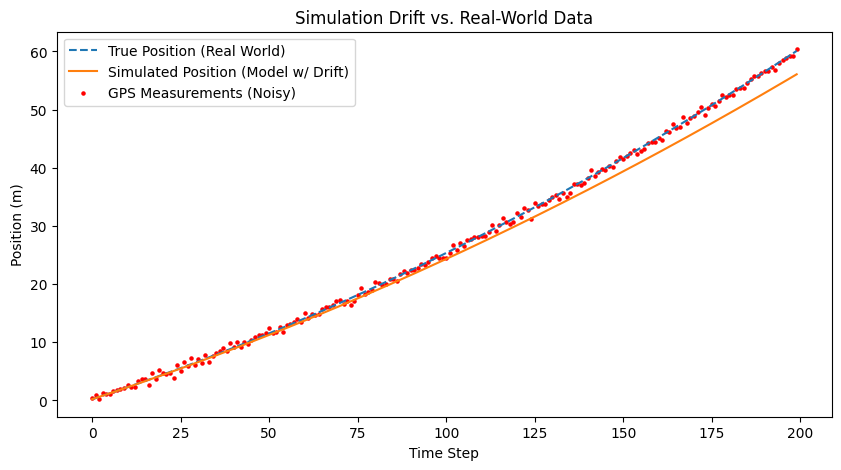

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Time step and duration
dt = 0.1  # Time step (s)
T = 20  # Total simulation time (s)
steps = int(T / dt)

# True car dynamics (real-world)
true_x = 0  # Initial position
true_v = 2  # True velocity (m/s)
true_a = 0.1  # True acceleration (m/s^2)

# Simulated car dynamics (imperfect model)
sim_x = 0
sim_v = 2
sim_a = 0.08  # Slightly incorrect acceleration

# Measurement noise parameters (GPS-like noise)
gps_noise_std = 0.5  # Standard deviation (m)

# Lists to store results
true_positions = []
sim_positions = []
gps_measurements = []

# Run the simulation
for _ in range(steps):
    # True motion (real-world)
    true_v += true_a * dt
    true_x += true_v * dt

    # Simulated motion (model, with incorrect acceleration)
    sim_v += sim_a * dt
    sim_x += sim_v * dt

    # GPS measurement with noise
    gps_x = true_x + np.random.normal(0, gps_noise_std)

    # Store values
    true_positions.append(true_x)
    sim_positions.append(sim_x)
    gps_measurements.append(gps_x)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(true_positions, label="True Position (Real World)", linestyle='dashed')
plt.plot(sim_positions, label="Simulated Position (Model w/ Drift)", linestyle='solid')
plt.scatter(range(len(gps_measurements)), gps_measurements, label="GPS Measurements (Noisy)", color='red', s=5)
plt.xlabel("Time Step")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Simulation Drift vs. Real-World Data")
plt.show()